[*********************100%***********************]  1 of 1 completed


Feature matrix X:       Open     High      Low    Close  Adj Close      Volume  DE Ratio  \
0  0.56475  0.57225  0.54550  0.55025   0.504661   715632000    17.221   
1  0.55450  0.55625  0.52525  0.54875   0.503285  1360000000    17.221   
2  0.55025  0.58575  0.54925  0.56325   0.516584  2030352000    17.221   
3  0.57050  0.57050  0.54175  0.54725   0.501909  1006652000    17.221   
4  0.55000  0.55000  0.53200  0.53600   0.491592   854108000    17.221   

   Return on Equity  Price/Book  Profit Margin  ...  MEDPRICE  TYPPRICE  \
0           1.23767   59.957767        0.55041  ...  0.558875  0.556000   
1           1.23767   59.957767        0.55041  ...  0.540750  0.543417   
2           1.23767   59.957767        0.55041  ...  0.567500  0.566083   
3           1.23767   59.957767        0.55041  ...  0.556125  0.553167   
4           1.23767   59.957767        0.55041  ...  0.541000  0.539333   

   WCLPRICE  HT_DCPERIOD  HT_DCPHASE  HT_PHASOR_inphase  HT_PHASOR_quadrature  \
0  0.

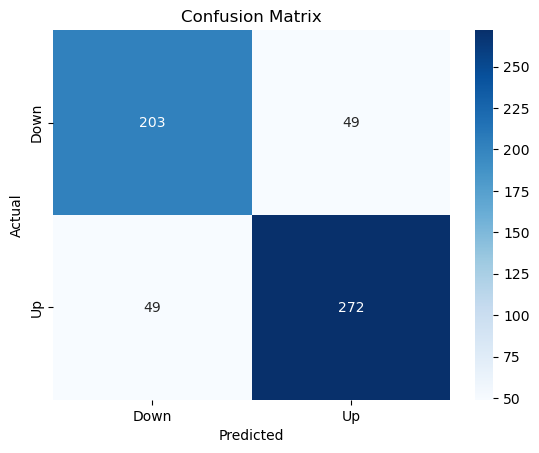

In [1]:
import sys
import os

# Get the absolute path to the `src` directory
src_path = os.path.abspath(os.path.join('..', 'src'))

# Add the `src` directory to the Python path
if src_path not in sys.path:
    sys.path.append(src_path)

# Import libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Import custom functions
from data_processing import fetch_tsla_data, calculate_technical_indicators
from train_boost import train_xgboost_with_timeseries_cv, prepare_data  # Updated function name
from genetic_algorithm import genetic_algorithm

# Prepare the data
X, y = prepare_data()
print("Feature matrix X:", X.head())
print("Target variable y:", y.head())

# Run the GA to identify the best subset of features
best_features = genetic_algorithm(X, y)
print("Best feature subset identified by GA:", best_features)

# Train the final XGBoost model using TimeSeriesSplit with the optimal feature subset
final_accuracy, models = train_xgboost_with_timeseries_cv(X, y, best_features)
print("Final average model accuracy with GA-selected features:", final_accuracy)

# Additional evaluation, if needed, on the final model
# Here, we use the last trained model in the list for predictions on the latest test split
X_final = X[best_features]

# Split the data based on the final TimeSeriesSplit
# Obtain the last split to use as our test set for evaluation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
train_index, test_index = list(tscv.split(X_final))[-1]  # Last split

X_train, X_test = X_final.iloc[train_index], X_final.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]
final_model = models[-1]  # Last model trained

# Predict on the test set
y_pred = final_model.predict(X_test)

# Display classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
